### Lab 6: Empirical comparison of classifiers over WTDT dataset 

Initial imports and function to load/save the dataset

In [2]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Auxiliary functions

def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y


def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)
        
#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)
print(X.shape)
print(y.shape)


(14000, 787)
(14000,)


# Analyzing/Understanding the problem

I started by analyzing the dataset to make an educated guess on what the best classifier might be.

The dataset has 140000 samples and 787 features divided equally among 7 fault classes, each with 2000 samples. Reading the introduction for this lab and the "considerationOnTheDataset.pdf", It seems the dataset represents fault classification data collected from multiple experimental repetitions rather than sequential, time-dependent recordings, which was my initial guess.

The 7 labels are one_hot encoded, which means that the dataset is organized like:

|X_0|X_1|X_2|...|X_786|y_0|y_1|y_2|y_3|y_4|y_5|y_6|

However, scikit-learn classifiers expect the labels in Categorical format, so the Y has to be converted, ending up in the following shape:

|X_0|X_1|X_2|...|X_786|y|

From the information given I made the following conclusions:
* **High Dimensionality**: 787 features per sample, there may be a way to improve performance if not all features are usefull
* **Multi-class Classification**: There are 7 fault classes, the dataset guesses which one the specific sample represents, by outputting a 0-6 value
* **Large Sample Size**: 14,000 samples in total, with balanced distribution across classes.
* **Non-Time Series Nature**: No temporal dependency from sample to sample 
___

I decided to take a look at the dataset to attempt some **feature engineering**:


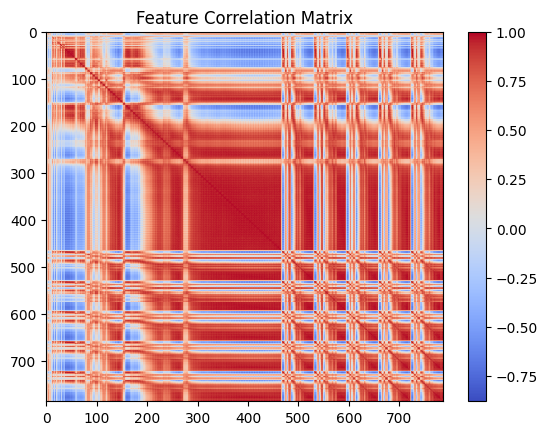

Min: -0.8780403783135924 Max: 1.0 Mean: 0.41511843653711533
(14000, 787)
(14000,)


In [3]:
corr_matrix = np.corrcoef(X.T)
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()  
plt.title("Feature Correlation Matrix")
plt.show()

import numpy as np
corr_matrix = np.corrcoef(X.T)
print("Min:", corr_matrix.min(), "Max:", corr_matrix.max(), "Mean:", corr_matrix.mean())

to_drop = []
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if corr_matrix[i, j] == 1.0:
            to_drop.append(j)

X_engineered = X[:, list(set(range(X.shape[1])) - set(to_drop))]

print(X.shape)
print(y.shape)

The data seems to have certain features combination where the correlation is extremely high, I was able to find some features that were perfectly correlated (correlation coefficient = 1), these features add no information and removing them may increase performance, removing them will also decrease the time it takes to train a model, since the dataset becomes effectively smaller.

Identifying and removing all redundant features I am left with 722 features, meaning that (787-722)=65 features are redundant.

I tried this initially but because the dataset present in the test server still has all 787 features it´s not so easy.

It would be possible to, instead of removing these features, to set all their values to None, this way the dataset keeps the same shape but we get rid of redundant features, I ended up not doing this, since I don´t believe it would solve any problem that I found.
___

Analyzing **entropy** for the features:

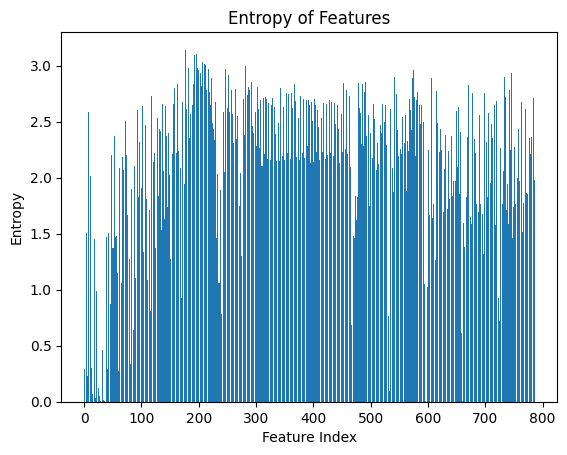

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import entropy

discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_discretized = discretizer.fit_transform(X)

feature_entropies = []
for i in range(X_discretized.shape[1]):
    feature_values, value_counts = np.unique(X_discretized[:, i], return_counts=True)
    value_probs = value_counts / len(X_discretized)
    feature_entropies.append(entropy(value_probs, base=2))

plt.bar(range(len(feature_entropies)), feature_entropies)
plt.title("Entropy of Features")
plt.xlabel("Feature Index")
plt.ylabel("Entropy")
plt.show()


Entropy varies a lot across all features but it´s never very large, in addition most features hover on the same relatively smaller values. If I was to remove all features with entropy larger than, for example, 2, the dataset would lose too much information. There is no apparent point to pursue this

___


Given the dataset's size, dimensionality, and multi-class nature, **Random Forest** is likely the best starting point due to its balance of performance, robustness to overfitting, and ability to handle high-dimensional features.

I will start with a benchmark to see how good it really is:

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into a training set and a test set, decided to keep random_state=42 to have reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 1.0


The accuracy is 100%, this was a suspicious result right away, if this is true, there is no competition, I will save the dataSet and test it in the server

In [3]:
saveSKLModel("T1-randomForest.pickle", model)

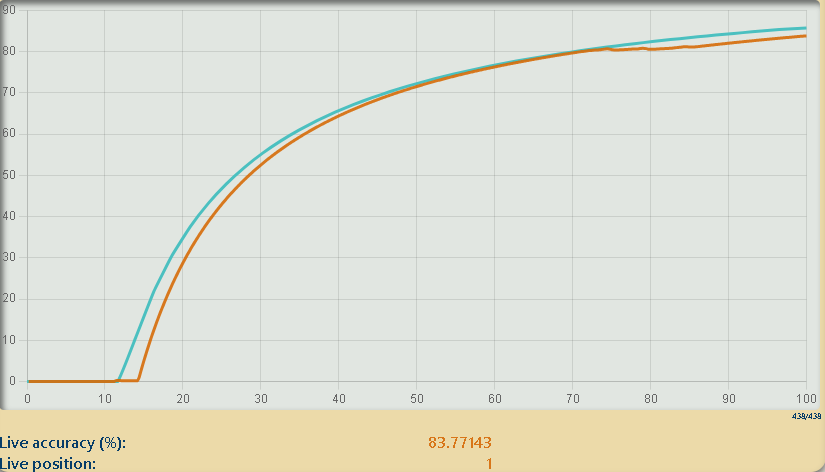

(In orange):
In the server, the accuracy is 83.77143%. This is not a bad result but there are some inconsistencies, there is a 16% difference in performance from my local test to the server test. Additionaly, analyzing the data I can see that the beggining 14% had an accuracy of almost 0%. The accuracy was also lower in the ending 28%.

At this time I though that the test dataset present in the server had been modified, by adding some noise to fault class 0, to make the challenge harder. Since the accuracy is really very low I made a small test to verify if this initial class was indeedn generalizable.

I trained the exact same mode, but this time only on the first 2000 samples, in order to maximize performance on that same class:

In [4]:
start_index = 0
end_index = 2000
X_train_0 = X[start_index:end_index]
y_train_0 = y[start_index:end_index]

# I add here also the random_state=42 to have reproducible results
model = RandomForestClassifier(random_state=42)
model.fit(X_train_0, y_train_0)
saveSKLModel("T1-randomForest.pickle", model)

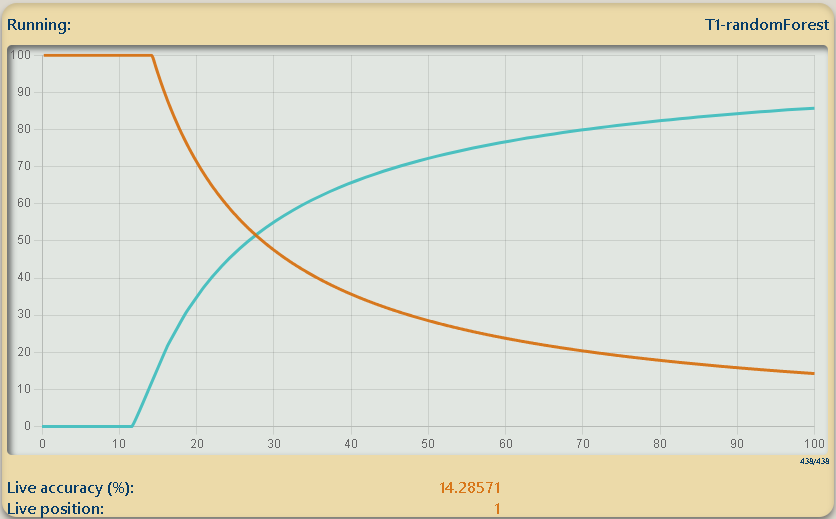

Clearly the class_0 is reproducible, but it seems like the model is unable to learn the first class when trained on the entire dataset. There is no class imbalance. The model may be overfitting, but in my local test I have very good performance (100%). Once again I though the initial class had been perturbed significantly, in order to make a harder competition.

So now I have 2 problems:

* I have no way to locally test, whether a model that I train is actually a better model (half of them have 100% accuracy)
* I have to find a way to create a model that generalizes well on every single class

Solution:
* I have to find a better way to measure performance
___

Possible solution: **Cross-Validation**

* In k-fold cross-validation, the dataset is split into k subsets (or folds).
* The model is trained on k-1 folds and tested on the remaining fold.
* This process is repeated k times, with each fold serving as the test set once.
* The final performance metric is the average of the results across all k folds.

In [5]:
from sklearn.model_selection import cross_val_score


model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X, y, cv=5)

print(f'Accuracy: {scores.mean()}')

Accuracy: 0.9988571428571428


Using **cross-validation** I can test more accurately if one set of hyperparameters is better than another one. However, this result is still very far away from what is seen in the test server. I will use this to try to evaluate the best hyperparameters, but this test is unable to tell me if a model is able to generalize well across all classes, even when there are significant differences between the train and test data, for this, I have to find another way to test the performance:

___
Another possible solution: **Create a new test data-set and perturb it to try to imitate server tests**:


Split the data in a test set and train set to simulate an out of sample test:

In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle

n_samples_per_class = 400

X_test_extracted = []
y_test_extracted = []
X_train_remaining = []
y_train_remaining = []

for fault_class in range(7):
    class_indices = np.where(y == fault_class)[0]
    class_X = X[class_indices]
    class_y = y[class_indices]

    class_X, class_y = shuffle(class_X, class_y, random_state=42)

    X_test_extracted.append(class_X[-n_samples_per_class:])
    y_test_extracted.append(class_y[-n_samples_per_class:])

    X_train_remaining.append(class_X[:-n_samples_per_class])
    y_train_remaining.append(class_y[:-n_samples_per_class])

X_test_extracted = np.vstack(X_test_extracted)
y_test_extracted = np.hstack(y_test_extracted)

X_train_remaining = np.vstack(X_train_remaining)
y_train_remaining = np.hstack(y_train_remaining)

test_output_file = "wtdt-test.pickle"
with open(test_output_file, "wb") as f:
    pickle.dump({'X': X_test_extracted, 'y': y_test_extracted}, f)

train_output_file = "wtdt-train.pickle"
with open(train_output_file, "wb") as f:
    pickle.dump({'X': X_train_remaining, 'y': y_train_remaining}, f)


Both new sets of data are well balanced, now, only in the test set, I will perturb the first class:

In [8]:
import pickle

with open("wtdt-test.pickle", "rb") as f:
    test_data = pickle.load(f)
X_test = test_data['X']
y_test = test_data['y']

noise_level = 1.0 
X_test_perturbed = X_test.copy()

class_0_indices = np.where(y_test == 0)[0]

overlap_indices = np.random.choice(
    np.where(y_test != 0)[0], len(class_0_indices), replace=False
)
X_test_perturbed[class_0_indices] = (
    X_test[overlap_indices] + np.random.normal(0, noise_level, X_test[overlap_indices].shape)
)

perturbed_output_file = "wtdt-test-perturbed.pickle"
with open(perturbed_output_file, "wb") as f:
    pickle.dump({'X': X_test_perturbed, 'y': y_test}, f)

Testing the new training/test sets:

Overall Test Accuracy: 0.8571

Accuracy per Fault Class:
Fault Class 0: 0.0000
Fault Class 1: 1.0000
Fault Class 2: 1.0000
Fault Class 3: 1.0000
Fault Class 4: 1.0000
Fault Class 5: 1.0000
Fault Class 6: 1.0000


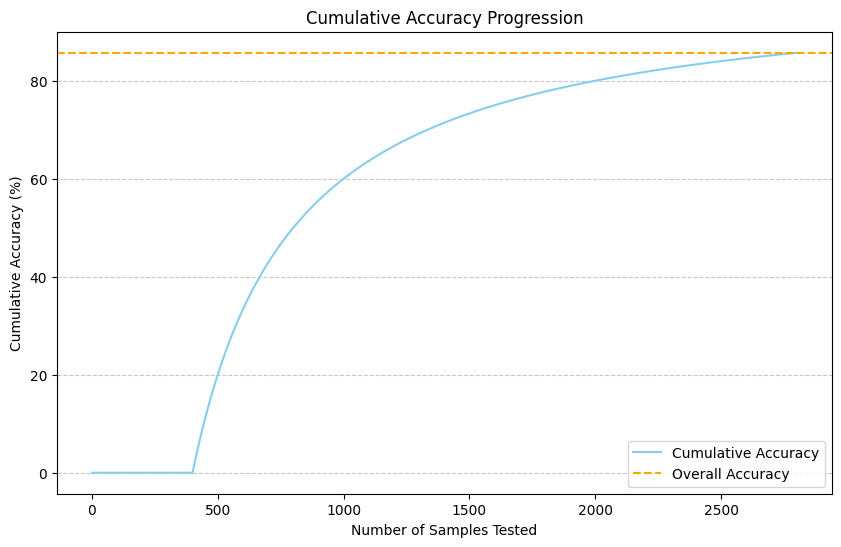

In [11]:
with open("wtdt-train.pickle", "rb") as f:
    train_data = pickle.load(f)
X_train = train_data['X']
y_train = train_data['y']
X_train.shape

# Load the test dataset (400 samples per class)
with open("wtdt-test-perturbed.pickle", "rb") as f:
    test_data = pickle.load(f)
X_test_perturbed = test_data['X']
y_test_perturbed = test_data['y']


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_perturbed = model.predict(X_test_perturbed)

overall_accuracy = accuracy_score(y_test_perturbed, y_pred_perturbed)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Accuracy per fault class (use y_test_windows instead of y_test)
print("\nAccuracy per Fault Class:")
for fault_class in range(7):  # Assuming 7 fault classes (0–6)
    class_indices = np.where(y_test_perturbed == fault_class)[0]
    y_true_class = y_test_perturbed[class_indices]
    y_pred_class = y_pred_perturbed[class_indices]

    # Compute accuracy for the current fault class
    if len(y_true_class) > 0:  # Avoid division by zero
        class_accuracy = accuracy_score(y_true_class, y_pred_class)
        print(f"Fault Class {fault_class}: {class_accuracy:.4f}")
    else:
        print(f"Fault Class {fault_class}: No samples in this class")

# Generate indices for cumulative accuracy calculation
indices = np.arange(len(y_test_perturbed))  # Based on sliding windows test labels

# Initialize variables to track cumulative accuracy
cumulative_correct = 0
cumulative_accuracies = []

# Compute cumulative accuracy
for i, index in enumerate(indices):
    # Check if the current prediction is correct
    if y_pred_perturbed[index] == y_test_perturbed[index]:
        cumulative_correct += 1

    # Calculate cumulative accuracy
    cumulative_accuracy = (cumulative_correct / (i + 1)) * 100
    cumulative_accuracies.append(cumulative_accuracy)

# Plotting cumulative accuracy progression
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, label="Cumulative Accuracy", color="skyblue")
plt.axhline(y=accuracy_score(y_test_perturbed, y_pred_perturbed) * 100, color='orange', linestyle='--', label="Overall Accuracy")
plt.xlabel("Number of Samples Tested")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy Progression")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The reported score for this test is 85%, which is much closer to the test server, with this test I can locally try to find a test that will generalize well across all fault classes.

I also made a graph to understand the data a little better, it is very simmilar to the one in the test server.

___

Now that I have 2 quality tests I can start to explore hyperparameters for using the **RandomForestClassifier**, I started using cross validation

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the Random Forest model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [1,2],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  
    verbose=2
)

# Perform grid search on the dataset
grid_search.fit(X, y)

# Retrieve the cross-validation results
cv_results = grid_search.cv_results_

# Print cross-validation scores for each fold for the best model
mean_cv_scores = cv_results['mean_test_score']  # Mean accuracy across folds
std_cv_scores = cv_results['std_test_score']  # Standard deviation across folds
print("Mean Cross-Validation Accuracy:", mean_cv_scores)
print("Standard Deviation of Cross-Validation Accuracy:", std_cv_scores)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mean Cross-Validation Accuracy: [0.97107143 0.97414286]
Standard Deviation of Cross-Validation Accuracy: [0.01081618 0.00571696]
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2}


I tried the GridSearch approach for a little bit, however it seems gridSearch cannot be easily used in conjunction with custom approaches such as cross-validation, there is also the problem that grid search tests every single possible combination of hyperparameters inserted, meaning it will take very long to test a relatively small number of models, this problem is exacerbated by my more expensive methods of evaluation.

___
Instead, I looked into **bayesian optimization**:

It is a probabilistic model-based optimization technique designed to efficiently find the maximum (or minimum) of an objective function that is expensive to evaluate. It can be used to suggest hyperparameter defined within specific ranges and guessing new values that may improve the result of the objective function, after each evaluation, it stores the result and uses it to guess new values to keep improving model.

There is **bayesian optimization** approach available inside scikit-learn, but it lacked some core features, so instead, I decided to use the **optuna** package. **Optuna** stores all results inside an SQLite db, allowing the starting/stopping of studys, and it allows us to verify at any points all the scores obtained with hyperparameter used.

I started with a simple approach using a larger hyperparameter search space for **RandomForest**:

(It´s important to note that these code snippets **will run forever** unless interrupted manually)

In [ ]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 500) 
    max_depth = trial.suggest_int("max_depth", 2, 50)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None, 10, 50, 100])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    
    return mean_accuracy

storage_name = "sqlite:///forest_study.db"

study = optuna.create_study(
    study_name="forest_optimization",
    direction="maximize",
    storage=storage_name,
    load_if_exists=True 
)

study.optimize(objective, n_jobs=1)


c:\Users\a932443\OneDrive - Eviden\Desktop\Uni\AM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-03 21:47:48,112] A new study created in RDB with name: forest_optimization
[I 2024-12-03 21:48:09,354] Trial 7 finished with value: -0.9960714285714285 and parameters: {'n_estimators': 23, 'max_depth': 44, 'max_features': 10, 'min_samples_split': 21, 'min_samples_leaf': 44}. Best is trial 7 with value: -0.9960714285714285.
[I 2024-12-03 21:49:05,224] Trial 1 finished with value: -0.9926428571428572 and parameters: {'n_estimators': 10, 'max_depth': 39, 'max_features': 100, 'min_samples_split': 30, 'min_samples_leaf': 30}. Best is trial 7 with value: -0.9960714285714285.


This simple example runs a lot better and is quickly able to find some improvements over the initial default hyperparameters.

The setting "*n_jobs=-1*" is dangerous, it trains models using every logical processor core available in the computer, making the computer unusable, possibly requiring a manual shutdown:

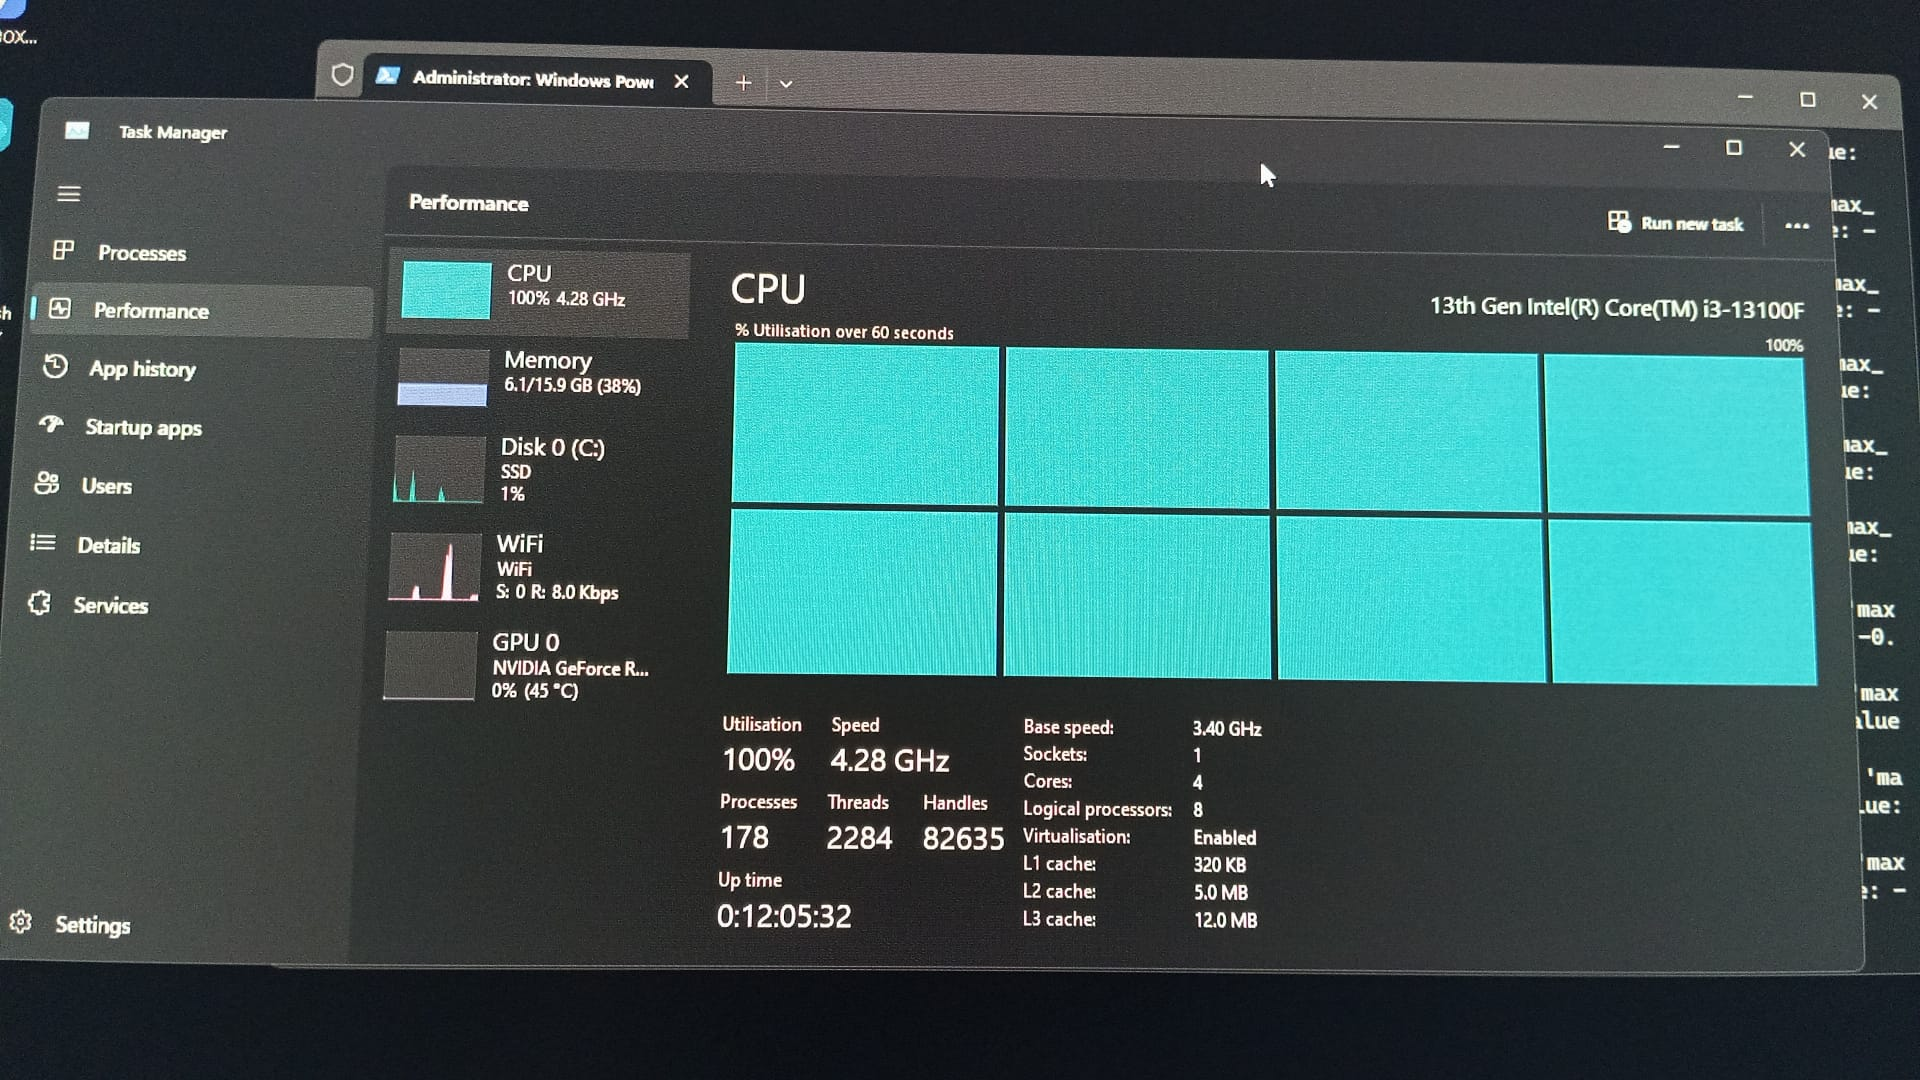

To avoid this, I will keep this option at a more conservative value, like n_jobs=2, setting it to "-1" only if I wont be at the computer.

Running this for a while, and saving/sending any models with improvements to the server, my score increase a little, going up to ~84.8%, but better models in my local test were rarely better performant in the server. I changed the function with a callback model, to save all model improvements and to save some models to send them later to the test server:

In [7]:
import random
import optuna

def on_better_model(study: optuna.Study, trial):
    print("Checking for better model...")
    if len(study.trials) > 0:
        should_save = random.random() < 0.1
        if study.best_trial == trial or should_save:
            # save the model
            saveSKLModel(f"T1-randomForest-{trial.number}.pickle", study.best_trial.model)

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 500) 
    max_depth = trial.suggest_int("max_depth", 2, 50)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None, 10, 50, 100])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    
    return mean_accuracy

storage_name = "sqlite:///forest_study.db"

study = optuna.create_study(
    study_name="forest_optimization",
    direction="maximize",
    storage=storage_name,
    load_if_exists=True
)

study.optimize(objective, n_jobs=1, n_trials=1) # Run only 1 trial for demonstration purposes


[I 2024-12-03 22:24:39,952] Using an existing study with name 'forest_optimization' instead of creating a new one.
[I 2024-12-03 22:28:36,847] Trial 5 finished with value: 0.9945714285714287 and parameters: {'n_estimators': 80, 'max_depth': 14, 'max_features': 100, 'min_samples_split': 79, 'min_samples_leaf': 23}. Best is trial 2 with value: 0.9984285714285714.


I was still unable to find a model capable of generalizing well to all fault classes, to attempt to fix this problem, I attempted different approaches, one of them was using a sliding window, I did this because at the moment, I believed what I had was a time series data-set, while I no longer believe that, there may be other reasons as to why the dataset responds well to this approach. However, using a sliding window to slice the data in smaller windows and using a small step size, I may be able to smooth variability in the data, allowing the model to focus on trends, rather than learning noise.
___
___

# Random Forest

I constructed a new bayesian otpimization study, including different sliding window parameters, I scored this study using the perturbed dataset created previoulsy, since my objective was to attempt to increase the score by increasing performance on the first fault class:

In [10]:
# Configuration that achieved the highest accuracy (takes ~1 hour to run, remove both local training tests to speed up)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

with open("wtdt-train.pickle", "rb") as f:
    train_data = pickle.load(f)
X_train = train_data['X']
y_train = train_data['y']
X_train.shape

# Load the test dataset (400 samples per class)
with open("wtdt-test-perturbed.pickle", "rb") as f:
    test_data = pickle.load(f)
X_test_perturbed = test_data['X']
y_test_perturbed = test_data['y']

def create_sliding_windows(data, labels, window_size, step=1):
    X_windows = []
    y_windows = []
    for i in range(0, len(data) - window_size + 1, step):
        X_windows.append(data[i:i + window_size].flatten())  # Flatten for RF compatibility
        y_windows.append(labels[i + window_size - 1])  # Label is the last element in the window
    return np.array(X_windows), np.array(y_windows)

windowSize = 17
step = 9

X_windows, y_windows = create_sliding_windows(X, y, windowSize, step)
X_windows_train, y_windows_train = create_sliding_windows(X_train, y_train, windowSize, step)
X_windows_test, y_windows_test = create_sliding_windows(X_test_perturbed, y_test_perturbed, windowSize, step)

n_estimators = 92
max_depth = 126
max_features = None
min_samples_split = 33
min_samples_leaf = 11

model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

model.fit(X_windows, y_windows)

y_pred_windows = model.predict(X_windows_test)
overall_accuracy_windows = accuracy_score(y_windows_test, y_pred_windows)
print(f"Overall Test Accuracy (Sliding Windows): {overall_accuracy_windows:.4f}")

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
mean_accuracy = np.mean(scores)
print(f"Cross-Validation Accuracy: {mean_accuracy:.4f}")

model.fit(X_windows, y_windows)

saveSKLModel("T1-randomForest.pickle", model)

Overall Test Accuracy (Sliding Windows): 0.8548
Cross-Validation Accuracy: 0.9919


Results for: **T1-randomForest**


The best hyper parameters found were:
* n_estimators = 92
* max_depth = 126
* max_features = None
* min_samples_split = 33
* min_samples_leaf = 11

Using a sliding window with the parameters:
* windowSize = 17
* step = 9

The scores associated were:
* Test server (Evaluation Accuracy): 85.71429%
* Local perturbed test: 
* Local cross-validation: 

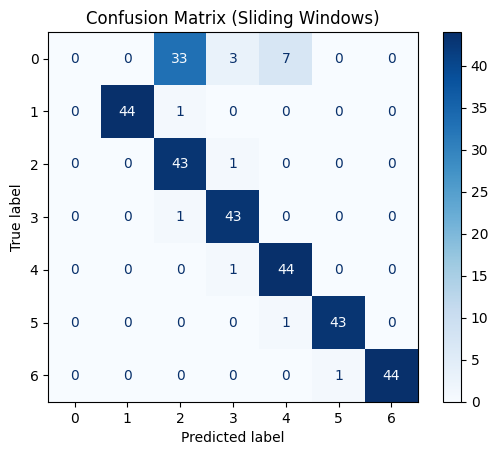

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_windows_test, y_pred_windows)

# Create and display the ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Sliding Windows)')
plt.show()


Considerations on the local perturbed test:

* Class 0 is significantly misclassified into Class 2/3/4 in this test
* classes 1 to 6 seem to have high accuracy, with very few errors
* There is no way of knowing if class 0 is also being misclassified into class 2/3/4 in the server test
* This is happening due to the noise added to the first class, but may give insight on what classes the first classe missclassifies into more commonly
* The dataset is balanced, all fault classes have the same number of total samples

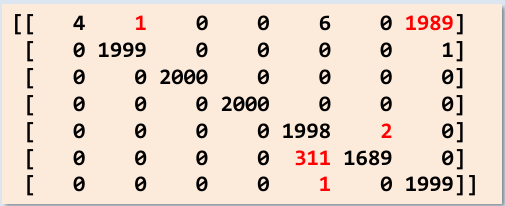

* Looking at the example given in the class, where the same training and test sets are used, it seems that class 0 is the one being misclassified, but into other classes, mostly class 7.

The

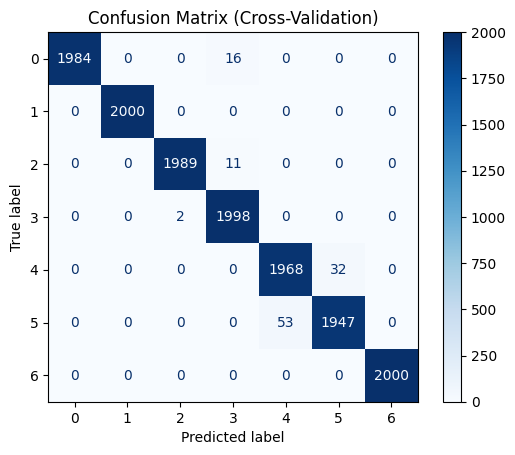

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtain predictions using cross-validation
y_pred = cross_val_predict(model, X, y, cv=5)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Cross-Validation)')
plt.show()


Considerations on the local cross-validation test:

# SVM

For SVM I found the best model using bayesian optimization and using the simulated perturbed test dataset

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

with open("wtdt-train.pickle", "rb") as f:
    train_data = pickle.load(f)
X_train = train_data['X']
y_train = train_data['y']
X_train.shape

# Load the test dataset (400 samples per class)
with open("wtdt-test-perturbed.pickle", "rb") as f:
    test_data = pickle.load(f)
X_test_perturbed = test_data['X']
y_test_perturbed = test_data['y']

steps = []
steps.append(("scaler", MinMaxScaler()))    

# Create the SVM model
steps.append(("svc", SVC(
    C=0.07938415731079503,
    kernel="rbf",
    max_iter=157,
    gamma="scale",
    random_state=42
)))

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
overall_accuracy_windows = accuracy_score(y_test, y_pred)
print(f"Overall Test Accuracy (Sliding Windows): {overall_accuracy_windows:.4f}")

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
mean_accuracy = np.mean(scores)
print(f"Cross-Validation Accuracy: {mean_accuracy:.4f}")

pipeline.fit(X, y)

saveSKLModel("T1-SVM.pickle", pipeline)

NameError: name 'X_windows' is not defined

Results for: **T1-SVM**


The best hyper parameters found were:
* C=0.07938415731079503,
* kernel="rbf",
* max_iter=157,
* gamma="scale"

Using a pipeline with the following:
* MinMaxScaler

The scores associated were:
* Test server (Evaluation Accuracy):
* Local perturbed test:
* Local cross-validation:

Considerations on the local perturbed test:

Considerations on the local cross-validation test:

# Logistic Regression

In [1]:
# Code


Results for: **T1-LogisticRegression**


The best hyper parameters found were:
* C=0.07938415731079503,
* kernel="rbf",
* max_iter=157,
* gamma="scale"

Using a pipeline with the following:
* MinMaxScaler

The scores associated were:
* Test server (Evaluation Accuracy):
* Local perturbed test:
* Local cross-validation: